In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import utils

plt.rcParams['figure.figsize'] = (12, 8)

/usr/local/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
conn = utils.load_connection()

In [4]:
mel_sql = '''
select *
from public.member_event_log
where "timestamp" > '2018-01-01'
'''

In [5]:
if os.path.exists('member_event_log.csv.gz'):
    df_mel = pd.read_csv('member_event_log.csv.gz', compression='gzip', low_memory=False)
    df_mel['timestamp'] = pd.to_datetime(df_mel['timestamp'])
else:
    df_mel = pd.read_sql(mel_sql, con=conn)
    df_mel.to_csv('member_event_log.csv.gz', compression='gzip', index=False)

In [6]:
df_mel.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
0,d90a85a0e9b872558709fd3d3413abaf,55a72b25469c64022e8c5e19,2018-01-20 00:38:32,site_access,3,NaN,0,web
1,f1db163a245391feafa2d7aeacc889a3,55a7992d469c649d2b8da515,2018-02-06 22:33:16,site_access,3,NaN,0,web
2,ee3a7c704be03906c6b03acf7c91efa2,55a7c020469c646a348b9a30,2018-05-07 16:22:30,site_access,3,NaN,0,web
3,f814a62ab9536cda318c28cc4bb41942,55a80fd2469c646a348c3431,2018-02-27 22:43:48,site_access,3,NaN,0,web
4,d73b6a683a3375b814eafbb0d80f552f,55a82048469c649e2b8ed5e0,2018-03-20 06:36:28,site_access,3,NaN,0,web


## Look at fields with null values.

In [7]:
# print each column and number of null values
utils.print_null_vals(df_mel)

,col,num_null,percent_null
0,event_id,0,0.000000
1,northstar_id,140,0.000019
2,timestamp,0,0.000000
3,action_type,0,0.000000
4,action_id,0,0.000000
5,source,1209252,0.161124
6,action_serial_id,1680272,0.223884
7,channel,0,0.000000


### NS IDs

In [8]:
df_mel[df_mel['northstar_id'].isnull()].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
2454735,53e15060db70b1d56167f1bbd717bfa8,NaN,2018-05-26 09:41:35.000000,clicked_link,7,1,01CEDX68XVTV6ZCHGQDVTZF7H5,email
2512663,9f26aaab8358db78e5d630099d4f105e,NaN,2018-06-26 11:44:17.000000,clicked_link,7,4,01CGXYH8935N409HG5P12GF8X1,email
2526293,29fd201ef1767c26371ebdb21bcc5922,NaN,2018-08-06 15:33:55.000000,clicked_link,7,3,01CM7XZ60EMREMEQ80X0EHHSFD,email
2651878,120dd53b7105561e380a4dac44223868,NaN,2018-07-26 21:54:10.000000,clicked_link,7,1,01CKC9BHQZPBZXXRBYXYMCWEAT,email
2658076,09f04d7d2c7855e0ebe3a5bd2918193f,NaN,2018-08-24 08:52:58.000000,clicked_link,7,2,01CNNJ5Z0E9GH8P23FXJAYFYHN,email
2849364,d442154bd9c93a4a66cc6bed261ef979,NaN,2018-05-28 10:57:27.000000,clicked_link,7,1,01CEK6AN9Y1QAC1YF5PBSENFCW,email
2965716,3435d7a211ca3666246d914cbfca045b,NaN,2018-07-30 14:00:00.798008,bertly_link_uncertain,10,bertly,e8efd5e8-86d4-48c8-ae95-0cbbd3802738,web
3002272,be13c2c02cc5271895498f1bb996b925,NaN,2018-07-27 20:50:33.297991,bertly_link_uncertain,10,bertly,b6e1ad25-eba1-4f97-a60e-ead205924e78,web
3009680,e3e7e7a7ed46281eab580d9f9836ffb5,NaN,2018-07-29 22:57:37.395024,bertly_link_uncertain,10,bertly,6debcef2-a5b7-4669-bc66-d19ad8d91c26,web
3070885,301af169993e06e72615e545cd29094c,NaN,2018-07-30 05:52:37.482881,bertly_link_uncertain,10,bertly,a2b06311-5f58-41e7-a3c2-08ef97a8fd7c,web


In [9]:
df_mel[df_mel['northstar_id'].isnull()]['action_type'].value_counts()

bertly_link_uncertain    100
bertly_link_click         33
clicked_link               6
bertly_link_preview        1
Name: action_type, dtype: int64

Is this related to the known issue of when pulling the northstar_id from a url string for bertly fails? Is there a way to safeguard against this?

### Source

In [10]:
df_mel[df_mel['source'].isnull()]['action_type'].value_counts()

site_access    648570
site_login     527813
signup          29783
post             3086
Name: action_type, dtype: int64

We expect site_access and site_login to have null sources, but should signups and posts?

In [11]:
df_mel[(df_mel['source'].isnull()) & (df_mel['action_type'] == 'signup')].head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
18456,3c671a97067f877fc21a7c454119b8a0,5585a742469c64e3608b51d1,2018-04-10 16:25:33,signup,1,NaN,9064166,web
18457,977a18f25a05ebcbd11e61bf4c5371a3,55a7a970469c646a348b5f21,2018-03-04 21:13:49,signup,1,NaN,8868042,web
18458,431d8569ab96492d485bae1ba4dbcaf4,55a81c82469c649e2b8ec9b8,2018-10-04 05:48:03,signup,1,NaN,9532612,web
18459,b86e2f5abde5f8f0ce155b022e8bfca5,55a896a9469c649e2b903af2,2018-01-08 03:18:44,signup,1,NaN,8496136,web
18460,f5308710215e12c84ce61cc64b31962b,55ad7c4c469c640d198be063,2018-03-17 14:52:23,signup,1,NaN,8969762,web


In [12]:
df_mel_check = df_mel[(df_mel['source'].isnull()) & (df_mel['action_type'] == 'signup')].set_index('timestamp').groupby(
    [pd.Grouper(freq='W')]
).agg({'northstar_id': lambda x: len(x.unique())})

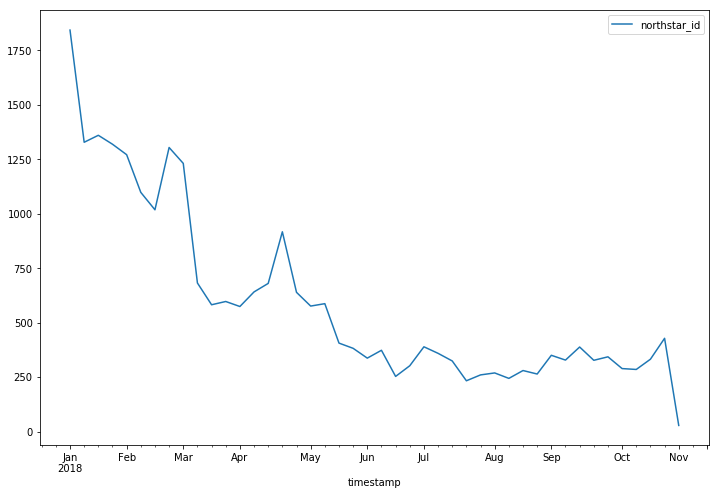

In [13]:
df_mel_check.plot();

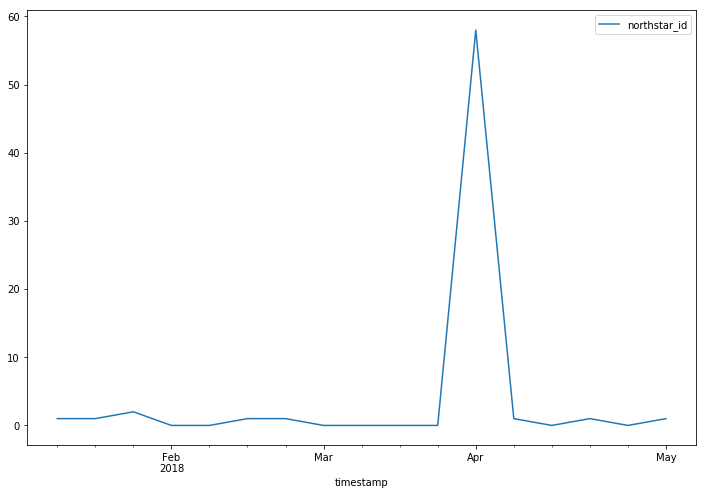

In [14]:
df_mel_check_posts = df_mel[(df_mel['source'].isnull()) & (df_mel['action_type'] == 'post')].set_index('timestamp').groupby(
    [pd.Grouper(freq='W')]
).agg({'northstar_id': lambda x: len(x.unique())}).fillna(0)
df_mel_check_posts.plot();

According to MEL sql logic, campaign signups and posts can also have a null source, in which case the channel is web. What cases is this capturing, and why has this occurrence decreased over time? 
- Biggest offenders according to rogue.signups are campaign_ids 3590 (8,402 unique ns ids), 2063 (1,342), 7822 (985) 

Same question for posts, why does this only seem to be an issue in the last week of March?
- Most of this generated from 3 campaign_ids = 467, 5411, 7314 and seem to occur on March 29?


### Action_serial_id

In [15]:
df_mel[df_mel['action_serial_id'] == '0']['action_type'].value_counts()

site_access         648570
site_login          527813
account_creation    503889
Name: action_type, dtype: int64

The above action types are expected.

## Duplicates

In [16]:
# The only single column I expect to be unique is the event_id, which it looks like they are.
df_mel[df_mel.duplicated('event_id')]

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel


In [17]:
# Another expectation might be the northstar_id, action_type, action_serial_id combination should be unique because
# the action_serial_id should be unique to a post/signup (given that Quasar keeps a log of posts/signups rather than 
# overwriting when updated as in Rogue)
df_dupes = df_mel[df_mel.duplicated(
    ['northstar_id', 'action_type', 'action_serial_id'], keep=False)].sort_values(['northstar_id', 'timestamp'])

# removing site access and site logins because action_serial_id always set to 0 and duplicates expected
df_dupes = df_dupes[~((df_dupes['action_type'] == 'site_login')| (df_dupes['action_type'] == 'site_access'))]

In [18]:
df_dupes.head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
2390819,bcc41300bad974ec14a86ff80913c70d,5543c402469c64bf3d8b457f,2018-04-02 16:27:40,clicked_link,7,1,01CA42ETJF84VBMFCDTJMP9CKN,email
2802867,dfeb58a177a8fde32101d4cd19565537,5543c402469c64bf3d8b457f,2018-04-02 20:27:40,clicked_link,7,1,01CA42ETJF84VBMFCDTJMP9CKN,email
2939284,c4ab979dd06c10f202be324562bdd960,5543eafd469c64bf3d8b4653,2018-04-02 16:30:38,clicked_link,7,1,01CA42QWR3JWM48C6J79J8HWSM,email
2807741,09e7710af9e9b0dff26e23bdefb0aa56,5543eafd469c64bf3d8b4653,2018-04-02 20:30:38,clicked_link,7,1,01CA42QWR3JWM48C6J79J8HWSM,email
2457291,573484a129f536728ecd3be53fdfb7d8,5543fb9c469c64ec7d8b4733,2018-03-20 18:23:26,clicked_link,7,1,01C92RB7EMNHQ6H8BX6JMZ0R3F,email
2407687,1f69162d8aa20bf1d8a81ae273c978c9,5543fb9c469c64ec7d8b4733,2018-03-20 22:23:26,clicked_link,7,1,01C92RB7EMNHQ6H8BX6JMZ0R3F,email
2540389,ca8ef418320081cb8e7cc75ead5886eb,5543fb9c469c64ec7d8b4733,2018-03-24 08:55:14,clicked_link,7,1,01C9C1W6G37DGV586BSBYAKJ47,email
2631704,89a322a9c6ee8a6b144ec56dc75471ff,5543fb9c469c64ec7d8b4733,2018-03-24 12:55:14,clicked_link,7,1,01C9C1W6G37DGV586BSBYAKJ47,email
2696083,391d520feffa4a62f517be2464a18de9,5543fb9c469c64ec7d8b4733,2018-03-28 13:21:46,clicked_link,7,1,01C9PT35QKZX6MSHH1E9NSGYH5,email
2734393,701e33b7b94583a39115af4d1674c8a7,5543fb9c469c64ec7d8b4733,2018-03-28 17:21:46,clicked_link,7,1,01C9PT35QKZX6MSHH1E9NSGYH5,email


In [19]:
df_dupes['northstar_id'].value_counts().head(10)

56dad08d469c64d8578b4f14    74
56daa439469c6444628b4d95    72
56dafb96469c6444628b4db5    66
56db2b2d469c64d8578b4f64    64
5a9b23f2a0bfad2e34699896    24
5a517200a0bfad6541202414    22
59dbaa60a0bfad082a6207c2    22
5a5ee751a0bfad793c61883b    20
59d7a716a0bfad17256c8e5a    20
59d2b090a0bfad02a813b46a    20
Name: northstar_id, dtype: int64

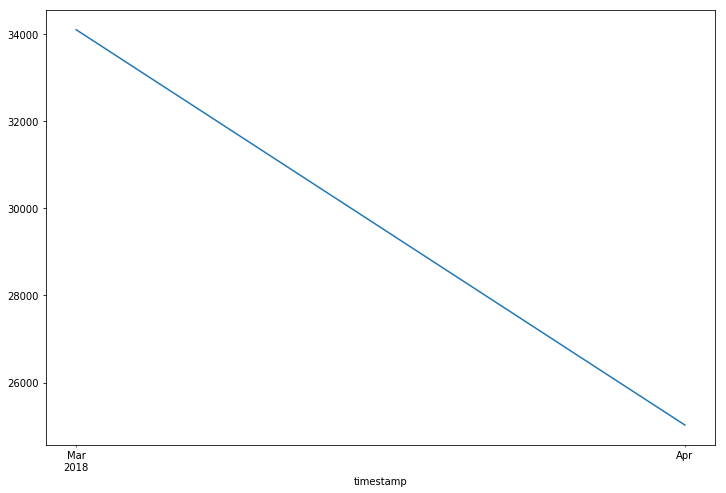

In [20]:
df_dupes.set_index('timestamp').groupby(pd.Grouper(freq='M'))['northstar_id'].count().plot()

Why are there duplicates where one timestamp is exactly 4 hours ahead of the other? This also only seems to be an issue in Mar/April.

In [21]:
# Another combination of fields that should potentially be unique are NS ids, timestamps, and action types.
# In which case, how were different action_serial_ids generated?
df_dupes2 = df_mel[df_mel.duplicated(
    ['northstar_id', 'timestamp', 'action_type'], keep=False)].sort_values(['northstar_id', 'timestamp'])

In [22]:
df_dupes2.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
3599978,38529c9b4577f02fa315112e3ab8a785,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.829585,bertly_link_uncertain,10,bertly,1133f90c-6485-408a-976a-d04cd3bf023f,sms
4129618,550a5e755608beaf5a2162ce8d85fdff,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.829585,bertly_link_uncertain,10,bertly,f5a614a0-0f57-4420-b57c-d555971431fe,sms
3200468,92d443681cf6766c5de3cbe5a9cdabcb,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.887231,bertly_link_uncertain,10,bertly,c04cf487-3e6b-4ebb-9450-0ca3e87f446a,sms
4757998,8d8ea32998fd5032c14f9799d4b883c3,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.887231,bertly_link_uncertain,10,bertly,26d61671-708b-4334-be52-84621c0ef3fd,sms
3134578,c4d782f32294dcb2b99cd09212164192,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:59.462954,bertly_link_uncertain,10,bertly,68a8d1e6-2248-4505-bb0f-b8ec5ec12f73,sms


In [23]:
# It seems like many of these are related to bertly clicks occuring before user agent strings were being captured.
df_dupes2['source'].value_counts()

SMS                26579
phoenix-next        3160
sms                 1926
1                    815
bertly               484
2                    370
turbovote             36
7                     16
8                      8
campaigns              6
niche                  4
3                      3
importer-client        3
5                      2
rock-the-vote          2
9                      2
Name: source, dtype: int64

In [24]:
df_dupes2[df_dupes2['source'] == 'SMS'].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
859885,739f12045d1ecf17a8a2732d9bb9fecb,554764a5469c64ed7d8b4f68,2018-09-06 16:46:12,messaged_gambit,6,SMS,5b9159d456e5e3000464c27b,sms
859886,c17d6cb0d5a1d5a4226da07d228227e2,554764a5469c64ed7d8b4f68,2018-09-06 16:46:12,messaged_gambit,6,SMS,5b9159d4b18c6a00040e9af5,sms
859887,55efd06a0059facd88f04a7c67325106,554764a5469c64ed7d8b4f68,2018-09-06 16:46:12,messaged_gambit,6,SMS,5b9159d4e309ed00043830ab,sms
859944,9c0894a88ebf17324dd2d5eb0cccc910,55479986469c64ec7d8b5085,2018-01-31 03:14:48,messaged_gambit,6,SMS,5a7134a83fa8aa0004713f15,sms
859945,8fc7070a954995cc6b650a804fd8a2f5,55479986469c64ec7d8b5085,2018-01-31 03:14:48,messaged_gambit,6,SMS,5a7134a86cfd310004722717,sms
859953,79b001a997767cd145df933c3f7a51bc,55479986469c64ec7d8b5085,2018-08-28 19:39:59,messaged_gambit,6,SMS,5b85a50f4b53610004be5039,sms
859954,8f3861df198a6e9606ad3af6662c8c2e,55479986469c64ec7d8b5085,2018-08-28 19:39:59,messaged_gambit,6,SMS,5b85a50fce46d90004536742,sms
860928,4b3c6ab8854586d55a9d8862e6c144cd,554a0e2c469c64bf3d8b5860,2018-01-23 21:05:09,messaged_gambit,6,SMS,5a67a3856340af00043e3306,sms
860929,2d79d555a152cf14c1208a9354108ee2,554a0e2c469c64bf3d8b5860,2018-01-23 21:05:09,messaged_gambit,6,SMS,5a67a3858d3c0c000475932d,sms
862204,838ceab434a94a5ae0981fbb6784fca5,5554cb62469c6455048b4570,2018-09-19 17:48:32,messaged_gambit,6,SMS,5ba28bf02217640004b60f65,sms


Looking at the gambit messages table for the first northstar ID, it's not clear what the expected behavior is for this action. It looks like this user tried to unsubscribe at least twice before these duplicates appeared. What do we want to count as member activity?

In [25]:
df_dupes2[df_dupes2['source'] == 'phoenix-next'].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
5246278,eb62e4712946498a7fed9eaf248f4a44,5553747b469c64ec7d8b7372,2018-07-10 06:16:40,signup,1,phoenix-next,9312378,web
5246279,3311b33cba6ffdb2dc7a580fa2811531,5553747b469c64ec7d8b7372,2018-07-10 06:16:40,signup,1,phoenix-next,9312379,web
5248584,29db0b222449f2862b469fa6770b70d7,556b59fb469c6416048b9ba2,2018-06-22 23:23:28,signup,1,phoenix-next,9282903,web
5248585,10221fd753559aaa2d58ba776e8f28ed,556b59fb469c6416048b9ba2,2018-06-22 23:23:28,signup,1,phoenix-next,9282904,web
5251091,c7de5a4600dd49556daebd594187863b,5574aaac469c648c778b4c9c,2018-07-10 15:00:05,signup,1,phoenix-next,9312852,web
5251092,579b96d61b0655ea2a1f9c25b7b6686b,5574aaac469c648c778b4c9c,2018-07-10 15:00:05,signup,1,phoenix-next,9312853,web
5252100,a08fabcc8257c76dddcfba50c216c8fc,5579e3c0469c648c778b6184,2018-08-08 06:13:33,signup,1,phoenix-next,9377474,web
5252101,5d508064daacb4bf32bac4b536752e17,5579e3c0469c648c778b6184,2018-08-08 06:13:33,signup,1,phoenix-next,9377475,web
5252570,819b95ddc4d71d1f4666e79f5dd34ef8,557f1089469c648c778b6f7f,2018-03-14 02:42:02,signup,1,phoenix-next,8961794,web
5252571,9d181f262db87d9ce0c6cb10d072faf8,557f1089469c648c778b6f7f,2018-03-14 02:42:02,signup,1,phoenix-next,8961795,web


In [26]:
df_dupes2[df_dupes2['source'] == 'sms'].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
6497079,bd3a28bb6649b6b7be31bdc05ddcdd91,55479986469c64ec7d8b5085,2018-01-30 22:14:49,post,2,sms,441716,sms
6497080,7edcb7631b22f79b803d52fb47278157,55479986469c64ec7d8b5085,2018-01-30 22:14:49,post,2,sms,441717,sms
6497082,9a2105f6f5978b9e1b56a8233ce2034e,55479986469c64ec7d8b5085,2018-08-28 19:40:00,post,2,sms,595945,sms
6497083,63349cb76f1d73c389b7cf5465b28bd1,55479986469c64ec7d8b5085,2018-08-28 19:40:00,post,2,sms,595946,sms
6497584,8b24147e00acc5e0bb225719f948eaa5,555520c4469c6430068b4dc5,2018-06-07 23:25:41,post,2,sms,540852,sms
6497585,40b695f9512f351574ebf0c5ccb4558d,555520c4469c6430068b4dc5,2018-06-07 23:25:41,post,2,sms,540853,sms
6498130,3118f630d80077c1e0f7067425ca3d86,55693e18469c6430068b9391,2018-06-07 20:17:53,post,2,sms,535116,sms
6498131,2ddd8191dc759f372cec6cc6401075c1,55693e18469c6430068b9391,2018-06-07 20:17:53,post,2,sms,535117,sms
6498516,587df9a2f325a2644a128f1e263bec1a,556f6597469c6430068bba4d,2018-01-30 20:35:21,post,2,sms,441469,sms
6498517,5bf9fa9e2711a1ff5ab8374a9e6c7a6b,556f6597469c6430068bba4d,2018-01-30 20:35:21,post,2,sms,441470,sms


Any reason why posts or signups would create duplicates? 

In [27]:
df_dupes2_bymonth = df_dupes2.set_index('timestamp').groupby([pd.Grouper(freq='M'), 'source']).agg(
    {'northstar_id': lambda x: len(x.unique())})

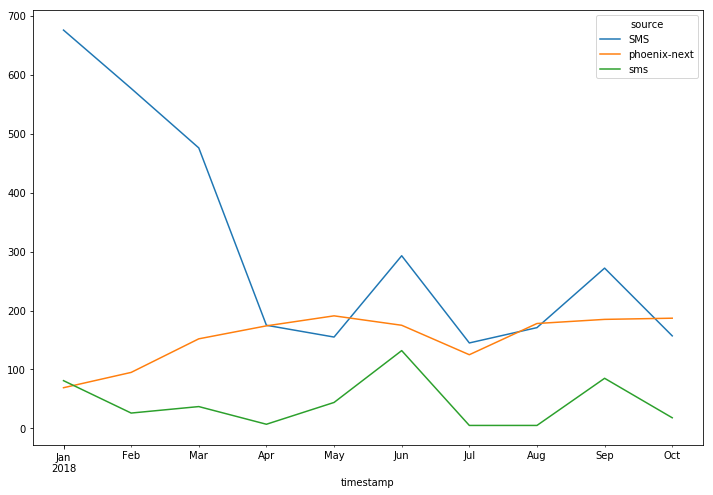

In [28]:
df_dupes2_bymonth.unstack().fillna(0)['northstar_id'][['SMS', 'phoenix-next', 'sms']].plot();

Possible bug in Gambit that's causing the spikes in June / Sept? 

### Look at action_type and channel combinations

In [29]:
df_mel.groupby(['channel', 'action_type']).agg({'northstar_id': lambda x: len(x.unique())})

northstar_id
channel              action_type                        
email                clicked_link                 122642
                     signup                           24
niche_coregistration account_creation              99290
                     signup                       112739
other                account_creation              88530
                     post                         221753
sms                  account_creation               6974
                     bertly_link_click            150006
                     bertly_link_preview          170848
                     bertly_link_uncertain        142240
                     messaged_gambit              455697
                     post                          27410
                     signup                       283348
web                  account_creation             309095
                     bertly_link_click              1379
                     bertly_link_preview               5
                     bertly_link_uncertain          2243
                     post                          57740
                     signup                       471745
                     site_access                  381545
                     site_login                   382042

Questions on above combinations:
- Other + account_creation: importer-client for voter registration? Should this go toward MAM counts?
- Other + post: RTV/TV, dev-oauth/rogue-oauth/rogue-admin, paw, importer-client --- do we want these sources to all count toward MAMs? 
- Web + bertly actions: I know that this is intended based on the target URL, but I guess it's not necessarily clear what source means (e.g. a link sourced from web vs email but sent via SMS?).
- How come we're no longer identifying voter reg as an action type? I know they were ingested as posts/signups, but this seems like a distinctive enough action type that maybe it shouldn't be fit into that paradigm / justifies having a separate table to pull from (rather than being incorporated into posts/signups). The benefits of that could be 

    1. Not having to deal with date discrepancies in two places.
    2. A more accurate accounting of activity through better being able to separate members from nonmembers: members would flow through the traditional journey of campaign signup --> 'post', while nonmembers wouldn't have 3 actions associated with them -- account creation, campaign signup, and post -- when they only knowingly performed 1?

### Check User ID consistency

In [30]:
def find_length(x):
    if isinstance(x, float):
        return 0
    else:
        return len(x)

In [31]:
df_mel['len_ns_id'] = df_mel['northstar_id'].apply(find_length)

In [32]:
df_mel['len_ns_id'].describe()

count    7.505103e+06
mean     2.399858e+01
std      1.131569e-01
min      0.000000e+00
25%      2.400000e+01
50%      2.400000e+01
75%      2.400000e+01
max      2.400000e+01
Name: len_ns_id, dtype: float64

In [33]:
df_mel[df_mel['len_ns_id'] != 24]['len_ns_id'].value_counts()

22    3607
0      140
5        2
6        1
Name: len_ns_id, dtype: int64

In [34]:
df_mel[df_mel['len_ns_id'] != 24]['action_type'].value_counts()

bertly_link_uncertain    3169
bertly_link_preview       488
bertly_link_click          87
clicked_link                6
Name: action_type, dtype: int64

In [35]:
df_mel[df_mel['len_ns_id'] != 24]['channel'].value_counts()

sms      3614
web       130
email       6
Name: channel, dtype: int64

Is this a known issue or related to the way that NS gets pulled for bertly table?

### Check source values

In [36]:
source_counts = df_mel.groupby(['action_type', 'source'])['northstar_id'].count()

In [37]:
for idx in source_counts.index.levels[0]:
    if idx not in ['site_access', 'site_login']:
        print(idx)
        print(source_counts[idx], '\n')

account_creation
source
GDPR                  722
aurora-oauth            1
importer-client     86862
niche               99290
nightwing-oauth         1
northstar             835
phoenix-next       276417
phoenix-oauth       32678
rogue-oauth             8
runscope-client       101
sms                  6974
Name: northstar_id, dtype: int64 

bertly_link_click
source
bertly    631761
Name: northstar_id, dtype: int64 

bertly_link_preview
source
bertly    1010593
Name: northstar_id, dtype: int64 

bertly_link_uncertain
source
bertly    415829
Name: northstar_id, dtype: int64 

clicked_link
source
1    316081
2    262946
3      2617
4       264
5        98
6       305
7      6488
8      3600
9      3219
Name: northstar_id, dtype: int64 

messaged_gambit
source
SMS    1530031
Name: northstar_id, dtype: int64 

post
source
dev-oauth                 3
importer-client       57084
paw                       6
phoenix-ashes           504
phoenix-next          87391
phoenix-web            6042
r

Could this use some cleanup?

### RTV Data Ingestion - Estimated Impact 

Compare RTV counts by import date vs. registered date to see the extent to which MAM might be inflated.

In [38]:
ca_vote_sql = '''
select *
from public.campaign_activity
where signup_created_at between '2018-01-01' and '2018-11-01' 
'''

df_ca = pd.read_sql(ca_vote_sql, con=conn)

In [39]:
# should signup source be importer-client for these rows in campaign activity, or rock-the-vote? 
df_ca[(df_ca['post_source'] == 'rock-the-vote')]['signup_source'].value_counts()

rock-the-vote      155835
phoenix-next         6513
sms                  2930
importer-client        18
Name: signup_source, dtype: int64

In [40]:
df_mel[df_mel['source'] == 'rock-the-vote']['action_type'].value_counts()

post      161312
signup    151984
Name: action_type, dtype: int64

In [41]:
df_mel[(df_mel['action_type'] == 'signup') & (
    df_mel['source'] == 'rock-the-vote')]['northstar_id'].value_counts().head()

5bb98041664abb00bc335482    2
5ba55d264a047f008c54cae7    2
5bc8fd6e92f7af00ce77b615    2
5bca09c292f7af00a9432456    2
5bd04a8f3f4bdf00b82d4484    2
Name: northstar_id, dtype: int64

In [42]:
df_mel[(df_mel['action_type'] == 'signup') & (df_mel['source'] == 'rock-the-vote') & (
    df_mel['northstar_id'] == '56fddf46469c647a428c138a')]

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel,len_ns_id
5342505,d9df3bc57c4a878459f9327830f259a3,56fddf46469c647a428c138a,2018-10-19 19:18:15,signup,1,rock-the-vote,9629460,web,24
5342506,f9f2df00d30fa9ec95bd946017b4e835,56fddf46469c647a428c138a,2018-10-19 21:10:31,signup,1,rock-the-vote,9634423,web,24


Remove duplicates in both tables keeping the most recent.

In [43]:
df_mel = df_mel.sort_values(['northstar_id', 'timestamp'])
df_mel = df_mel[~((df_mel['action_type'] == 'signup') & (df_mel['source'] == 'rock-the-vote') & (
    df_mel.duplicated(['northstar_id', 'action_type', 'source'], keep='last')))]

In [44]:
df_mel = df_mel[~((df_mel['action_type'] == 'post') & (df_mel['source'] == 'rock-the-vote') & (
    df_mel.duplicated(['northstar_id', 'action_type', 'source'], keep='last')))]

In [45]:
df_ca = df_ca.sort_values(['northstar_id', 'post_created_at'])
df_ca = df_ca[~((df_ca['post_source'] == 'rock-the-vote') & (df_ca['signup_source'] == 'rock-the-vote') & (
    df_ca.duplicated(['northstar_id', 'post_source', 'signup_source'], keep='last')))]

Visualize count differences.

In [46]:
reg_counts_bymonth = df_ca[(df_ca['post_source'] == 'rock-the-vote')].set_index('post_created_at').groupby(
    pd.Grouper(freq='M'))['northstar_id'].count()

In [47]:
reg_counts_bymonth

post_created_at
2018-05-31     4439
2018-06-30     8628
2018-07-31    18549
2018-08-31    21006
2018-09-30    43078
2018-10-31    69181
Freq: M, Name: northstar_id, dtype: int64

In [48]:
chompy_counts_bymonth = df_mel[(df_mel['source'] == 'rock-the-vote') & (df_mel['action_type'] == 'post')].set_index('timestamp').groupby(
    pd.Grouper(freq='M'))['northstar_id'].count()

In [49]:
chompy_counts_bymonth

timestamp
2018-08-31       808
2018-09-30         0
2018-10-31    159087
Freq: M, Name: northstar_id, dtype: int64

In [50]:
merged_df = pd.merge(
    reg_counts_bymonth.reset_index().rename(columns={'post_created_at': 'timestamp'}),
    chompy_counts_bymonth.reset_index(),
    on='timestamp',
    how='left',
    suffixes=('_reg', '_chompy')
).fillna(0)

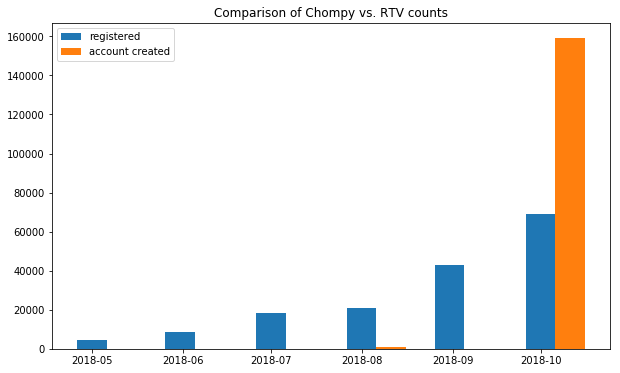

In [51]:
fig, ax = plt.subplots()
ax.bar(
    merged_df['timestamp'].values - pd.Timedelta(days=30), merged_df['northstar_id_reg'], width=10, label='registered')
ax.bar(
    merged_df['timestamp'].values - pd.Timedelta(days=20), merged_df['northstar_id_chompy'], width=10, label='account created')
ax.legend()
fig.set_size_inches(10, 6)
ax.set_title('Comparison of Chompy vs. RTV counts');

If we were to look at the remaining members who did not actually register to vote in October, did they perform another action that would still make them active that month?

In [52]:
mel_ns_ids = df_mel[(df_mel['source'] == 'rock-the-vote') & (df_mel['action_type'] == 'post') & (
df_mel['timestamp'] >= '2018-10-01')]['northstar_id']

In [53]:
ca_ns_ids = df_ca[
    (df_ca['post_source'] == 'rock-the-vote') & (df_ca['post_created_at'] >= '2018-10-01')]['northstar_id']

In [54]:
mel_remaining_ns_ids = list(set(mel_ns_ids) - set(ca_ns_ids))

In [55]:
len(mel_remaining_ns_ids)

94062

In [56]:
df_mel.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel,len_ns_id
3539488,a6bbe374c565de9342fa51d8ea68fd2d,340749,2018-09-13 16:23:41.231462,bertly_link_preview,10,bertly,30d7b772-a4b3-49ab-9351-aa9f963a8d27,sms,6
5244357,28413a8b5e181bdd735604827a8fd26f,54fa272b469c64d7068b4567,2018-05-15 19:25:41.000000,signup,1,turbovote,9176055,web,24
6496899,aaedec1375b7ad51670c96ff271b3561,54fa272b469c64d7068b4567,2018-05-15 19:25:41.000000,post,2,turbovote,489534,other,24
4868020,f25ef2381c27f754fe1b53916c6cc0ff,54fa272d469c64d7068b4577,2018-09-10 22:28:09.078788,bertly_link_preview,10,bertly,5aac556e-b594-4f2f-a964-95523c5810f2,sms,24
859255,4cd5b0972e6af977a1fbf7760322ac5c,54fa272e469c64d7068b457e,2018-07-18 01:54:55.000000,messaged_gambit,6,SMS,5b4e9defb6499d00049a85d8,sms,24


In [57]:
df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote') & (df_mel['source'] == 'importer-client')]['action_type'].value_counts()

account_creation    41171
Name: action_type, dtype: int64

The biggest contributor to MAMs is account creation, but these are all generated by an importer-client, suggesting that they were accounts created by us for nonmembers who had registered to vote. Not including those... 

In [58]:
df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote') & (df_mel['source'] != 'importer-client')]['action_type'].value_counts()

bertly_link_click      9670
clicked_link           5382
site_access            3636
signup                 3238
bertly_link_preview    3185
messaged_gambit        2511
site_login             1855
post                    562
account_creation        141
Name: action_type, dtype: int64

In [59]:
print('Count if we include importer-client account creation: ', len(df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote')
]['northstar_id'].unique()))

print('Count if we do not include those: ', len(df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote') & 
    (df_mel['source'] != 'importer-client')
]['northstar_id'].unique()))

Count if we include importer-client account creation:  48123
Count if we do not include those:  7384


In [60]:
mam_count_bymonth = df_mel.set_index('timestamp').groupby(
    pd.Grouper(freq='M')).agg({'northstar_id': lambda x: len(x.unique())})

In [61]:
mam_count_bymonth

,northstar_id
timestamp,
2018-01-31,260189
2018-02-28,226427
2018-03-31,216263
2018-04-30,141322
2018-05-31,95034
2018-06-30,129257
2018-07-31,193245
2018-08-31,226623
2018-09-30,231882


In [62]:
mam_count_byactivity_oct = df_mel[df_mel['timestamp'] > '2018-10-01'].groupby(
    'action_type').agg({'northstar_id': lambda x: len(x.unique())})

In [63]:
mam_count_byactivity_oct

,northstar_id
action_type,
account_creation,117187
bertly_link_click,53882
bertly_link_preview,80629
clicked_link,19006
messaged_gambit,22134
post,165486
signup,192489
site_access,47054
site_login,43942


In [64]:
# remove rock-the-vote users if they did not actually register in October
df_mel_oct = df_mel[(df_mel['timestamp'] >= '2018-10-01')]

df_mel_oct_reduced = df_mel_oct[~(
    df_mel_oct['northstar_id'].isin(mel_remaining_ns_ids) &
    (df_mel_oct['source'] == 'rock-the-vote'))]

In [65]:
len(df_mel_oct_reduced['northstar_id'].unique())

284306

In [66]:
# remove rock-the-vote users and those whose actions were an account created by an importer-client
df_mel_oct_reduced_2 = df_mel_oct[~(
    df_mel_oct['northstar_id'].isin(mel_remaining_ns_ids) & 
    ((df_mel_oct['source'] == 'rock-the-vote') | (df_mel_oct['source'] == 'importer-client')))]

In [67]:
len(df_mel_oct_reduced_2['northstar_id'].unique())

243567

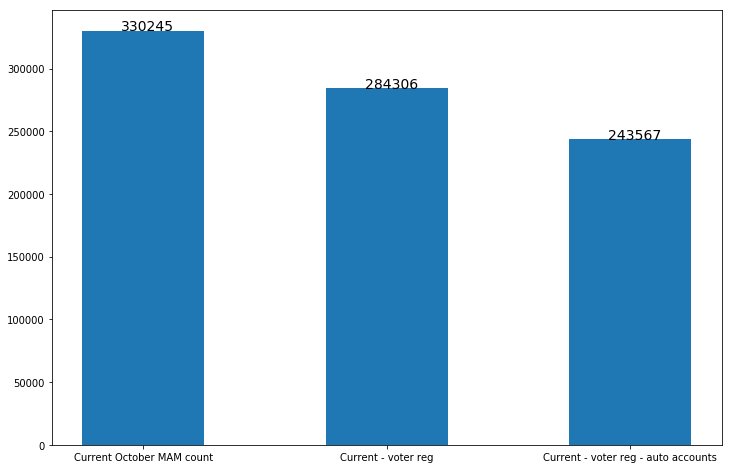

In [68]:
# plot to look at impact on October

fig1, ax1 = plt.subplots()
ax1.bar(x=[0, 1, 2], 
        height=[
            mam_count_bymonth.iloc[-1], 
            len(df_mel_oct_reduced['northstar_id'].unique()), 
            len(df_mel_oct_reduced_2['northstar_id'].unique())],
        width=0.5
       )
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Current October MAM count', 'Current - voter reg', 'Current - voter reg - auto accounts'])
ax1.text(-0.09, mam_count_bymonth.iloc[-1], s=str(mam_count_bymonth.iloc[-1].values[0]), fontsize=14)
ax1.text(0.91, len(df_mel_oct_reduced['northstar_id'].unique()), 
         s=str(len(df_mel_oct_reduced['northstar_id'].unique())), fontsize=14)
ax1.text(1.91, len(df_mel_oct_reduced_2['northstar_id'].unique()), 
         s=str(len(df_mel_oct_reduced_2['northstar_id'].unique())), fontsize=14);


In [69]:
mam_count_bymonth_updated = mam_count_bymonth.copy()

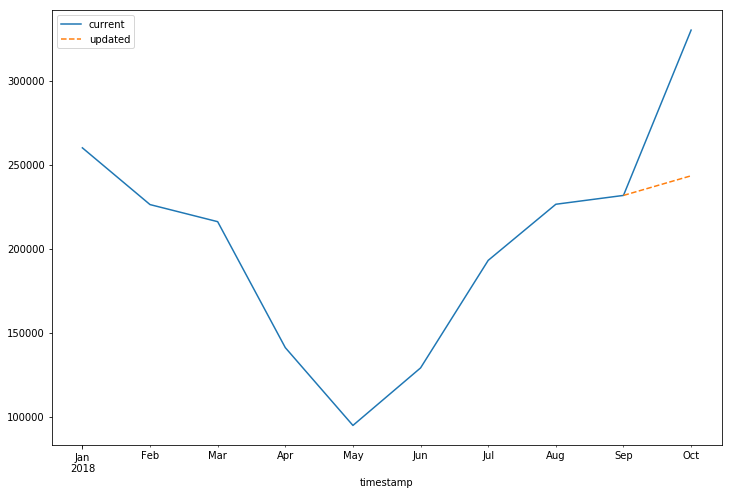

In [70]:
fig2, ax2 = plt.subplots()
mam_count_bymonth.plot(ax=ax2)
mam_count_bymonth_updated.iloc[-1] = len(df_mel_oct_reduced_2['northstar_id'].unique())
mam_count_bymonth_updated.iloc[-2:].plot(ax=ax2, linestyle='dashed')
ax2.legend(labels=['current', 'updated'])

What caused the dip in MAMs in April/May/June?